# Imports and Setup

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
MAIN_DIR = "/kaggle/input/cafa-5-protein-function-prediction"

This notebook will create dataset to be used for training. The notebook have to run on Kaggle. The dataset will be saved in the output folder. The dataset will be used for training in the next notebook.

# Creating Labels

Let's start by loading the terms and IDs. Terms will be loaded from the competition dataset. The IDs are available along with the embeddings. We will use `t5embeds` for IDs.

In [3]:
train_terms = pd.read_csv( os.path.join(MAIN_DIR, "Train", "train_terms.tsv"),sep="\t")
print(train_terms.shape)

(5363863, 3)


In [4]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [5]:
train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
train_protein_ids_df = pd.DataFrame({"EntryID":train_protein_ids})
print(len(train_protein_ids_df))
train_protein_ids_df.head()

142246


,EntryID
0,P20536
1,O73864
2,O95231
3,A0A0B4J1F4
4,P54366


We can see that the `train_terms` has far more rows than the IDs. This is because there are more than one GO term for a fiven ID. We will groupby the `EntryID`:

In [6]:
train_terms_g = train_terms.groupby("EntryID").agg({
    "term": lambda x: ",".join(x),
    "aspect": lambda x: ", ".join(set(x))
})
train_terms_g.reset_index(drop=False, inplace=True)
train_terms_g.columns

Index(['EntryID', 'term', 'aspect'], dtype='object')

In [7]:
train_terms_g.head()

,EntryID,term,aspect
0,A0A009IHW8,"GO:0008152,GO:0034655,GO:0072523,GO:0044270,GO...","BPO, MFO"
1,A0A021WW32,"GO:0048869,GO:0048856,GO:0022008,GO:0065007,GO...","CCO, BPO"
2,A0A021WZA4,"GO:0071944,GO:0005575,GO:0110165,GO:0016020,GO...",CCO
3,A0A023FBW4,"GO:0019956,GO:0005488,GO:0003674,GO:0019955,GO...",MFO
4,A0A023FBW7,"GO:0019957,GO:0019956,GO:0005488,GO:0003674,GO...",MFO


Next, merge the two dataframes on `EntryID`:

In [8]:
train_protein_ids_df_ = pd.merge(train_protein_ids_df, train_terms_g, on = "EntryID", how="inner")

We will make sure that the entry IDs are in the same order as the embeddings are in this order.

In [9]:
#make sure that the entry IDS are in the same order
assert np.all(train_protein_ids_df_["EntryID"] == train_protein_ids_df["EntryID"])

In [10]:
train_protein_ids_df_.head()

,EntryID,term,aspect
0,P20536,"GO:0008152,GO:0071897,GO:0044249,GO:0006259,GO...","BPO, MFO"
1,O73864,"GO:0061371,GO:0048589,GO:0051641,GO:0048856,GO...","CCO, BPO, MFO"
2,O95231,"GO:0006357,GO:0010557,GO:0045935,GO:0065007,GO...","CCO, BPO, MFO"
3,A0A0B4J1F4,"GO:0008152,GO:0051234,GO:0036211,GO:0070727,GO...","CCO, BPO, MFO"
4,P54366,"GO:0005622,GO:0043229,GO:0043226,GO:0110165,GO...","CCO, MFO"


In [11]:
train_terms["term"].nunique()

31466

There are 31466 different GO terms. We will not be using all the terms as some of them are very rare. Let's try to visualize how many terms will be sufficient for our case.

In [12]:
term_counts = train_terms["term"].value_counts()
term_count_percentage = (term_counts/len(train_terms))*100
term_count_percentage_cumsum = term_count_percentage.cumsum()
term_count_percentage_cumsum

GO:0005575      1.732184
GO:0008150      3.451281
GO:0110165      5.153152
GO:0003674      6.619203
GO:0005622      7.938868
                 ...    
GO:0031772     99.999925
GO:0042324     99.999944
GO:0031771     99.999963
GO:0051041     99.999981
GO:0102628    100.000000
Name: term, Length: 31466, dtype: float64

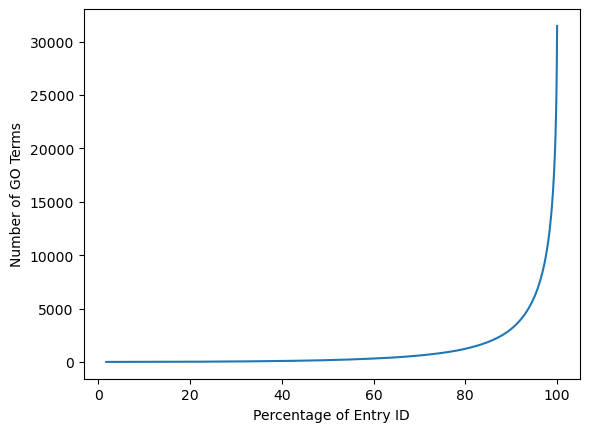

In [13]:
plt.plot(term_count_percentage_cumsum.values, range(len(term_counts)))
plt.xlabel("Percentage of Entry ID")
plt.ylabel("Number of GO Terms");

We can see that the percentage rises, the number of GO terms required rises very slowly for about 90% and then a large number of GO terms are required to cover even 1% of the IDs. We can set a threshold, say 90%, and take only those GO terms that are necessary for explianing this threshold.

In [14]:
threshold = 86
total_terms_required = (term_count_percentage_cumsum<=threshold).sum()
total_terms_required

2054

Based on this, we will be using 2000 GO terms for our case which explains about 86% of IDs.

> Note that we can not choose a lot of GO terms as while submitting, we have to submit the probabilities for all the selected GO terms. If a large terms are selected, it will result in a large file that might not fit in memory.

In [15]:
# Set the limit for label
num_of_labels = 2000

# Take value counts in descending order and fetch first 5000 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()
labels = np.array(labels)
labels.shape, labels

((2000,),
 array(['GO:0005575', 'GO:0008150', 'GO:0110165', ..., 'GO:0005746',
        'GO:0050866', 'GO:0008589'], dtype='<U10'))

Now, we are ready to create the matrix of labels. This will have a shape of $(m, n)$, where $m$ is the number of samples, in our case $142246$ and $n$ is the number of GO terms, in our case $5000$. This will be a sparse matrix, filled with zeroes except where the GO term is. The following loop calculates this.

In [16]:
one_hot_labels = np.zeros((train_protein_ids_df_.shape[0], num_of_labels))
for i in tqdm(range(len(train_protein_ids_df_)), "Calculating labels..."):
    ls = train_protein_ids_df_.loc[i, "term"]
    for l in ls.split(","):
        one_hot_labels[i, :] += (labels == l).astype(float)

Calculating labels...: 100%|██████████| 142246/142246 [04:14<00:00, 559.00it/s]


In [17]:
print(one_hot_labels.shape)
one_hot_labels.sum(axis = 1)

(142246, 2000)


array([ 31., 140.,  62., ...,  31.,  91.,  20.])

We can see that the first entry has 33 GO terms, second 162, third 62 and so on. This will be our labels. Let's save it. We will also add the EntryID as the ID has different order for different embeddings.

In [18]:
final_labels = pd.DataFrame(one_hot_labels, columns = labels)
final_labels["EntryID"] = train_protein_ids_df
final_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142246 entries, 0 to 142245
Columns: 2001 entries, GO:0005575 to EntryID
dtypes: float64(2000), object(1)
memory usage: 2.1+ GB


In [19]:
final_labels.to_parquet("final_train_labels.parquet", index = False)

We have used `parquet` to save the data because the labels are very sparse and saving them in parquet will result in a very small file size as compared to saving them in CSV. Just try it, if you don't believe me!

# The Embeddings

Now that we have the labels, we only need embeddings. We will be using the embeddings:

- T5 : https://www.kaggle.com/datasets/sergeifironov/t5embeds

- ProtBERT : https://www.kaggle.com/datasets/henriupton/protbert-embeddings-for-cafa5

- EMS2 : https://www.kaggle.com/datasets/viktorfairuschin/cafa-5-ems-2-embeddings-numpy

Let's have a look at the IDs first:

In [20]:
train_id1 = np.load("/kaggle/input/t5embeds/train_ids.npy")
train_id2 = np.load("/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_ids.npy")
train_id3 = np.load("/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy")

In [21]:
assert len(train_id1) == len(train_id2) == len(train_id3)

In [22]:
np.all(train_id1 == train_id2), np.all(train_id2 == train_id3), np.all(train_id1 == train_id3)

(False, False, True)

In [23]:
test_id1 = np.load("/kaggle/input/t5embeds/test_ids.npy")
test_id2 = np.load("/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_ids.npy")
test_id3 = np.load("/kaggle/input/protbert-embeddings-for-cafa5/test_ids.npy")

In [24]:
len(test_id1), len(test_id2), len(test_id3)

(141865, 141864, 141865)

In [25]:
np.all(test_id1 == test_id3)

True

It seems that only the ID from 1 and 3 have the same order. For 2, the order is different. What's more, test ID is also missing a row from the secnd embedding. While saving, we will ignore the second embedding, as we are not going to use it later.

In [26]:
np.save("train_id.npy", train_id1)
np.save("test_id.npy", test_id1)

Now, for embeddings.

In [27]:
train_embedding_1 = np.load("/kaggle/input/t5embeds/train_embeds.npy")
train_embedding_2 = np.load("/kaggle/input/protbert-embeddings-for-cafa5/train_embeddings.npy")
test_embedding_1 = np.load("/kaggle/input/t5embeds/test_embeds.npy")
test_embedding_2 = np.load("/kaggle/input/protbert-embeddings-for-cafa5/test_embeddings.npy")

Note that we are not using the embedding from EMS.

In [28]:
np.save("t5_train_embedding.npy", train_embedding_1)
np.save("t5_test_embedding.npy", test_embedding_1)
np.save("prptbert_train_embedding.npy", train_embedding_2)
np.save("prptbert_test_embedding.npy", test_embedding_2)

In [29]:
!ls -lh

total 3.3G
---------- 1 root root 526K Jul 30 11:47 __notebook__.ipynb
-rw-r--r-- 1 root root 9.6M Jul 30 11:47 final_train_labels.parquet
-rw-r--r-- 1 root root 555M Jul 30 11:47 prptbert_test_embedding.npy
-rw-r--r-- 1 root root 556M Jul 30 11:47 prptbert_train_embedding.npy
-rw-r--r-- 1 root root 1.1G Jul 30 11:47 t5_test_embedding.npy
-rw-r--r-- 1 root root 1.1G Jul 30 11:47 t5_train_embedding.npy
-rw-r--r-- 1 root root 5.5M Jul 30 11:47 test_id.npy
-rw-r--r-- 1 root root 5.5M Jul 30 11:47 train_id.npy


This gives us the dataset we need. Now, we can use this to train nueral network.